In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random
from einops.layers.torch import Rearrange
from einops import rearrange

from typing import Any, Dict, Tuple, Optional
from game_mechanics import (
    ChooseMoveCheckpoint,
    ShooterEnv,
    checkpoint_model,
    choose_move_randomly,
    human_player,
    load_network,
    play_shooter,
    save_network,
)
from tqdm.notebook import tqdm

from functools import partial
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from copy import deepcopy
from functools import partial

from utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
TEAM_NAME = "Hristo"  # <---- Enter your team name here!
assert TEAM_NAME != "Team Name", "Please change your TEAM_NAME!"

In [44]:
device = 'cpu'

In [45]:
def choose_move(state, neural_network: nn.Module) -> int:
    probs = neural_network(state.to(device))
    probs = probs.cpu().detach().numpy()
    move = np.random.choice(range(6), p=probs)
    return int(move)

In [51]:
policy = nn.Sequential(
    nn.Linear(35, 1000),
    nn.LeakyReLU(),
    nn.Linear(1000, 6),
    nn.Softmax(dim=-1)
)

V = nn.Sequential(
    nn.Linear(35, 1000),
    nn.LeakyReLU(),
    nn.Linear(1000, 1000),
    nn.LeakyReLU(),
    nn.Linear(1000, 1),
    nn.Tanh()
)



gamma = 0.99
lamda = 0.99
erm = EpisodeReplayMemory(gamma, lamda)
optimizer_policy = torch.optim.Adam(policy.parameters(), lr=0.001)
optimizer_value = torch.optim.Adam(V.parameters(), lr=0.005)

episodes_per_stage = 1000
batch_size = 1000
n_stages = 10
gradient_steps = 3
env = ShooterEnv(opponent_choose_move=choose_move_randomly)

policy.to(device)
V.to(device)

Sequential(
  (0): Linear(in_features=35, out_features=1000, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=1000, out_features=1000, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=1000, out_features=1, bias=True)
  (5): Tanh()
)

In [52]:
loss_policies = []
loss_values = []
results = []
for stage in tqdm(range(n_stages)):
    if stage <= 2:
        include_barriers = False
    else:
        include_barriers = True
    if stage <= 5:
        half_sized_game = True
    else:
        half_sized_game = False
    opponent = deepcopy(policy)
    env = ShooterEnv(opponent_choose_move=choose_move_randomly, #partial(choose_move, neural_network = opponent), 
                     game_speed_multiplier=100_000,
                     include_barriers=include_barriers,
                     half_sized_game=half_sized_game)
    for episode in tqdm(range(episodes_per_stage)):
        old_observation, reward, done, info = env.reset()
        old_observation = add_features(old_observation).to(device)
        old_observation = old_observation.to(device)
        old_value = V(old_observation)
        while not done:
            probs = policy(old_observation)
            chosen_move = np.random.choice(range(0,6), p=probs.detach().cpu().numpy())
            observation, reward, done, info = env.step(int(chosen_move))
            observation = observation.to(device)
            observation = add_features(observation).to(device)
            value = V(observation)
            
            erm.append({
                'old_observation': [old_observation.cpu()],
                'observation': [observation.cpu()],
                'reward': reward,
                'done': done,
                'chosen_move': chosen_move,
                'value': value.item(),
                'old_value': old_value.item()
            })
            old_value = value
            
        results.append(reward)
        if episode % 10 == 0:
            print(sum(results) / (len(results) + 0.01) / 2 + 0.5)
        if len(erm) >= batch_size:
            data = erm.sample_with_remove(batch_size)
            states = data['old_observation'].to(device)
            old_probs = policy(states)
            old_values = V(states)
            
            # value function
            loss_v = F.smooth_l1_loss(old_values[:,0], data['gae'][0].to(device))
            loss_values.append(loss_v.item())
            optimizer_value.zero_grad()
            loss_v.backward()
            optimizer_value.step()
            
            value_estimates = old_values[:,0].detach()
            
            # policy
            epsilon = 0.05
            old_probs = old_probs[range(batch_size), data['chosen_move'].long()].detach()
            for step in range(gradient_steps):
#                 print('========')
#                 print('making a grad step...')
                new_probs = policy(data['old_observation'].to(device))#[0]
                new_probs = new_probs[range(batch_size), data['chosen_move'].long()]
#                 print(f'unclipped prob_ratio: {new_probs / old_probs}')
                prob_ratio = new_probs / old_probs
                prob_ratio = torch.min(prob_ratio, torch.clamp(prob_ratio, 1-epsilon, 1+epsilon))
#                 print(f'after clipping: {prob_ratio}')
                scale = (data['gae'].to(device) - value_estimates)
                loss_policy = (- prob_ratio * (data['gae'].to(device) - value_estimates)).mean()
                loss_policies.append(loss_policy.item())
#                 print(f'loss: {loss_policy.item()}')
#                 print(len(erm))
#                 pol_params_before_update = [weight.clone().detach() for name, weight in policy.named_parameters()]
    
                optimizer_policy.zero_grad()
                loss_policy.backward()
                optimizer_policy.step()
#                 old_probs = new_probs.detach()
                
#                 pol_params_after_update = [weight.clone().detach() for name, weight in policy.named_parameters()]
#                 pol_update_strengths = [((pol_params_before_update[_i] - pol_params_after_update[_i]).std() /
#                          (pol_params_before_update[_i]).std()).log10().item()
#                         for _i in range(len(pol_params_before_update))]
#                 print(pol_update_strengths)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.995049504950495
0.6362397820163488
0.571394574012375
0.5483714930667527
0.4634235552304316
0.39217800431287986
0.3606785772824127
0.33805097873538936
0.30866559683989636
0.2857378310075816
0.2772497772497773
0.27029096477794795
0.2479547144864061
0.23666132356308678
0.21987802283525987
0.21193960664856631
0.19877647351096206
0.18715279808198348
0.17681343572178332
0.16755667242552746
0.1592209342818765
0.15167527605326758
0.14481245192525222
0.13854378598329076
0.13279531969627817
0.12949683279550617
0.12453545841155511
0.12363012434965498
0.11923063236183762
0.11513350056699079
0.11296966878176806
0.10933732034339733
0.10593127939939567
0.10424156369898191
0.10118471599073342
0.09830204267684678
0.0955790698318606
0.09300288401929868
0.09056192750846431
0.0882458249149638
0.08604523577965634
0.08395172866840223
0.08195767321441294
0.08005614718916032
0.0782408562164123
0.0765060641670916
0.07484653261317542
0.0732574679943101
0.07173447537473232
0.07027351785096025
0.068870880820742

  0%|          | 0/1000 [00:00<?, ?it/s]

0.034470185113035845
0.03412923709953414
0.033794967728033976
0.03346718266554155
0.03314569504615711
0.03283032511584094
0.0325208998972677
0.03221725287345589
0.031919223688957554
0.03162665786748059
0.031339406544899695
0.03105732621668572
0.03078027849885373


KeyboardInterrupt: 

In [53]:
len(results)

1124

In [54]:
a = pd.Series(results)

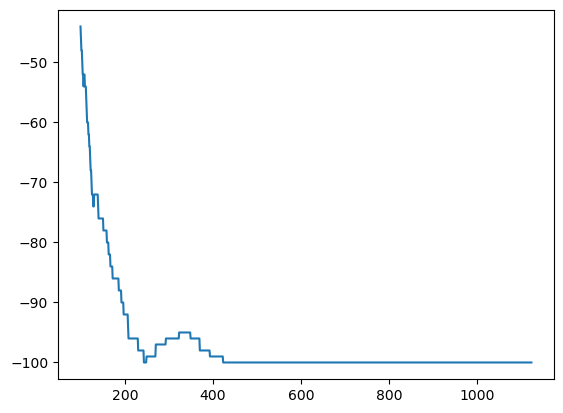

In [55]:
plt.plot(a.rolling(100).sum())

In [18]:
observation

tensor([ 8.6667e-01,  8.2222e-01, -9.6593e-01,  2.5882e-01,  8.6667e-01,
         8.2222e-01, -1.0000e+00, -1.8370e-16, -1.0000e+00, -1.0000e+00,
         0.0000e+00,  1.0000e+00, -1.0000e+00, -1.0000e+00,  0.0000e+00,
         1.0000e+00, -1.0000e+00, -1.0000e+00,  0.0000e+00,  1.0000e+00,
        -1.0000e+00, -1.0000e+00,  0.0000e+00,  1.0000e+00])

In [150]:
erm.current_episode

,old_observation,observation,reward,done,chosen_move,value,old_value
66a31dc3-81db-4bc8-bace-072c989ca52f,"[tensor(-0.8000), tensor(-0.0044), tensor(-1.)...","[tensor(-0.8000), tensor(-0.0044), tensor(-0.9...",0,False,1,0.243774,0.251183
2c5b2f45-1506-433e-89f5-69a8ed192ed1,"[tensor(-0.8000), tensor(-0.0044), tensor(-1.)...","[tensor(-0.8000), tensor(-0.0044), tensor(-1.)...",0,False,0,0.252986,0.243774
0394f96d-f2d7-4cd3-aec7-d6c492c3c92d,"[tensor(-0.8000), tensor(-0.0044), tensor(-1.)...","[tensor(-0.8000), tensor(-0.0044), tensor(-1.)...",0,False,3,0.342607,0.252986
d49e0289-b1f1-49ae-a7a8-40e564414993,"[tensor(-0.8000), tensor(-0.0044), tensor(-1.)...","[tensor(-0.8000), tensor(-0.0044), tensor(-0.9...",0,False,1,0.337770,0.342607
d76e89fe-5f9b-40de-8014-ed2d7c042a0a,"[tensor(-0.8000), tensor(-0.0044), tensor(-1.)...","[tensor(-0.8000), tensor(-0.0044), tensor(-1.)...",0,False,0,0.338040,0.337770
cc246c3c-0704-48b6-929a-65e51719a30a,"[tensor(-0.8000), tensor(-0.0044), tensor(-1.)...","[tensor(-0.8000), tensor(-0.0044), tensor(-0.9...",1,True,1,0.332001,0.338040


In [141]:
a = np.array([1,2,23])

In [143]:
np.isnan(a)

array([False, False, False])

In [55]:
loss_policies

[0.04580307751893997,
 0.04538275673985481,
 0.04538275673985481,
 0.04441700875759125,
 0.04428017511963844,
 0.04428017511963844,
 nan,
 nan,
 nan]

In [54]:
loss_values

[0.07869274914264679, 0.1371116042137146, 0.10709716379642487]

In [48]:
loss_values

[0.07577092200517654, 0.5277934670448303, nan]

In [49]:
loss_policies

[-25.790035247802734,
 -25.632057189941406,
 -25.632057189941406,
 21.198654174804688,
 20.76930046081543,
 20.76930046081543,
 nan,
 nan,
 nan]

In [24]:
data.shape

AttributeError: 'dict' object has no attribute 'shape'

In [25]:
probs

tensor([nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

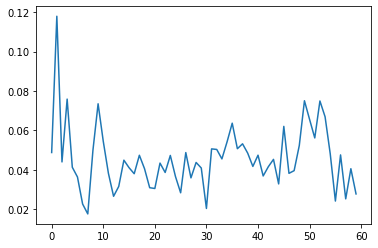

In [80]:
plt.plot(loss_values)

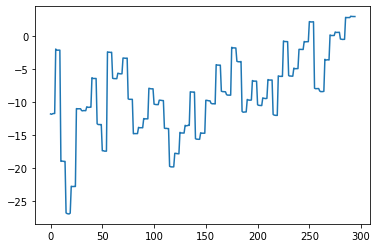

In [81]:
plt.plot(loss_policies)

In [83]:
observation

tensor([ 0.0000e+00,  8.2222e-01,  1.2246e-16, -1.0000e+00, -4.5880e-01,
         3.1809e-01, -8.6603e-01, -5.0000e-01, -1.0000e+00, -1.0000e+00,
         0.0000e+00,  1.0000e+00, -1.0000e+00, -1.0000e+00,  0.0000e+00,
         1.0000e+00, -1.0363e-01,  5.9415e-01,  0.0000e+00,  1.0000e+00,
        -1.0000e+00, -1.0000e+00,  0.0000e+00,  1.0000e+00], device='cuda:0')

In [90]:
list(policy.parameters())

[Parameter containing:
 tensor([[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [84]:
policy(observation)

tensor([nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [28]:
data['gae'][0]

tensor([3.8235e-01, 6.9762e-01, 7.4128e-01, 2.9270e-02, 8.3587e-02, 1.8198e-02,
        6.8271e-03, 1.8021e-02, 4.8586e-01, 2.1420e-01, 1.7268e-03, 2.2728e-03,
        5.4260e-03, 3.7001e-03, 1.1367e-01, 4.8583e-03, 1.8209e-01, 7.4309e-02,
        2.7997e-03, 8.6750e-04, 3.4431e-02, 1.8908e-03, 5.5186e-02, 1.3229e-01,
        1.5385e-02, 2.9386e-03, 1.3438e-03, 9.8189e-01, 2.1852e-01, 2.1765e-02,
        2.3808e-03, 1.2458e-03, 1.8427e-03, 1.2357e-02, 2.9949e-03, 3.4743e-03,
        4.4196e-03, 6.7387e-02, 4.3495e-02, 6.5765e-01, 8.8628e-03, 3.0114e-01,
        3.1846e-02, 2.3719e-03, 6.1361e-03, 7.5821e-02, 4.2542e-02, 8.0455e-03,
        1.3519e-02, 2.2640e-03, 2.9367e-03, 6.0410e-03, 3.8994e-03, 4.2244e-01,
        1.4379e-01, 3.0043e-03, 2.2706e-03, 8.8574e-03, 2.6185e-01, 2.8968e-01,
        2.3582e-03, 1.0108e-01, 1.0273e-02, 1.4060e-01, 2.7629e-03, 6.4749e-02,
        2.1305e-03, 1.2675e-03, 4.8234e-02, 2.9818e-03, 2.3608e-03, 6.5279e-04,
        1.0798e-03, 1.7783e-03, 1.0936e-

In [27]:
data['chosen_move']

tensor([[1., 4., 4., 5., 1., 1., 1., 0., 3., 0., 3., 5., 3., 5., 2., 0., 4., 1.,
         4., 5., 0., 4., 4., 1., 4., 4., 1., 0., 5., 4., 4., 0., 4., 1., 4., 2.,
         1., 4., 1., 0., 1., 0., 4., 5., 5., 5., 4., 0., 0., 0., 4., 3., 5., 5.,
         4., 0., 1., 3., 3., 5., 1., 1., 2., 1., 4., 2., 3., 3., 2., 4., 5., 2.,
         0., 0., 2., 0., 2., 5., 1., 4., 1., 3., 5., 1., 2., 0., 0., 2., 0., 2.,
         2., 2., 0., 2., 0., 2., 2., 5., 3., 2.]])

In [26]:
old_values.device

device(type='cuda', index=0)

In [ ]:
device

In [9]:
results

[-1, 1]

In [69]:
len(erm)

1214

In [67]:
new_probs

tensor([0.1775, 0.1418, 0.1555, 0.1769, 0.1842, 0.1641],
       grad_fn=<SelectBackward>)

In [18]:
np.atan2(state[2], state[3])

AttributeError: module 'numpy' has no attribute 'atan2'

In [ ]:
state.move()

In [4]:
state

tensor([ 8.0000e-01,  0.0000e+00, -1.0000e+00, -1.8370e-16, -8.0000e-01,
         0.0000e+00, -1.0000e+00, -1.8370e-16, -1.0000e+00, -1.0000e+00,
         0.0000e+00,  1.0000e+00, -1.0000e+00, -1.0000e+00,  0.0000e+00,
         1.0000e+00, -1.0000e+00, -1.0000e+00,  0.0000e+00,  1.0000e+00,
        -1.0000e+00, -1.0000e+00,  0.0000e+00,  1.0000e+00])

In [17]:
state

tensor([ 8.0000e-01,  0.0000e+00, -1.0000e+00, -1.8370e-16, -8.0000e-01,
         0.0000e+00, -1.0000e+00, -1.8370e-16, -1.0000e+00, -1.0000e+00,
         0.0000e+00,  1.0000e+00, -1.0000e+00, -1.0000e+00,  0.0000e+00,
         1.0000e+00, -1.0000e+00, -1.0000e+00,  0.0000e+00,  1.0000e+00,
        -1.0000e+00, -1.0000e+00,  0.0000e+00,  1.0000e+00])

In [11]:
torch.round?

In [2]:
play_shooter(
    your_choose_move=human_player,
    opponent_choose_move=choose_move_randomly,
    game_speed_multiplier=1,
    render=True,
    include_barriers=False,
    half_game_size=False,
)

1.0